In [32]:

import numpy as np
import plotly.graph_objects as go
from editolidoProxy import get_nearby_wmo, load_ofp_route, get_nearest_wmo_results, wmo_grid


In [33]:
ofp_route = load_ofp_route('ofp/AF264_24FEB21_CDG_Dossier de Vol OFP 5-0-1.route.json')
route = np.array([[float(p.latitude), float(p.longitude)] for p in ofp_route])
results = get_nearest_wmo_results(ofp_route, wmo_grid)

# plane_route is not exactly the route, it is the route points corresponding to the meteo route
plane_route = np.radians(np.array([[float(r.fpl.latitude), float(r.fpl.longitude)] for r in results]))
path = np.radians(np.array([[float(r.ogimet.latitude), float(r.ogimet.longitude)] for r in results]))

In [34]:
stations = np.array([[float(p.latitude), float(p.longitude)] for p in get_nearby_wmo(ofp_route)])

In [35]:
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')

distances = dist.pairwise(path, plane_route)

In [36]:
from scipy.spatial.distance import cosine
def compute_penalty(path):
    return sum([cosine(path[i+1]-path[i], path[i]- path[i-1]) for i in range(1,len(path)-1)])



In [37]:
def l2_loss(distances, indices):
    dd = distances[:, indices]
    return sum(dd.min(axis=1))

In [38]:
def global_loss(path, route, distances, indices, l):
    return (np.log(l2_loss(distances, indices)) + l*compute_penalty(path[indices]))/len(indices)


In [39]:
from itertools import combinations
from tqdm import tqdm

In [55]:
def find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l):
    min_loss_path = path
    for k in tqdm(range(min_points_to_remove+1)):
        min_loss = 1000
        if len(min_loss_path) <= len(path) - min_points_to_remove:
            break
        for p in combinations(range(1,len(path)-1), k):
            indices = [i for i in range(len(path)) if i not in p]
            new_loss = global_loss(path, plane_route, distances, indices, l)
            if new_loss < min_loss and len(indices) >= len(path) - min_points_to_remove:
                min_loss = new_loss
                min_loss_path = path[indices]

    best_loss = global_loss(min_loss_path, plane_route, distances, [i for i in range(len(min_loss_path))], l )
    losses = [best_loss]
    current_path = min_loss_path
    best_path = min_loss_path
    print("length after min_removal", len(current_path))
    for k in tqdm(range(max_points_to_remove-min_points_to_remove+1)):
        for p in combinations(range(1,len(current_path)-1), k):
            indices = [i for i in range(len(current_path)) if i not in p]
            new_loss = global_loss(current_path, plane_route, distances, indices, l)
            if new_loss < best_loss:
                best_loss = new_loss
                losses.append(new_loss)
                best_path = current_path[indices]
    print("length after optimization", len(best_path))
    return best_path, losses

In [ ]:
min_points_to_remove = len(path) - 22
max_points_to_remove = 2
best_paths = []
print("Meteo route length:", len(path))
for l in [10]:
    opt_path = find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l)
    best_paths.append(np.degrees(opt_path[0]))
    print(len(best_paths[-1]), opt_path[1])

  0%|          | 0/69 [00:00<?, ?it/s]

Meteo route length: 90


  7%|▋         | 5/69 [1:35:45<35:00:06, 1968.85s/it]

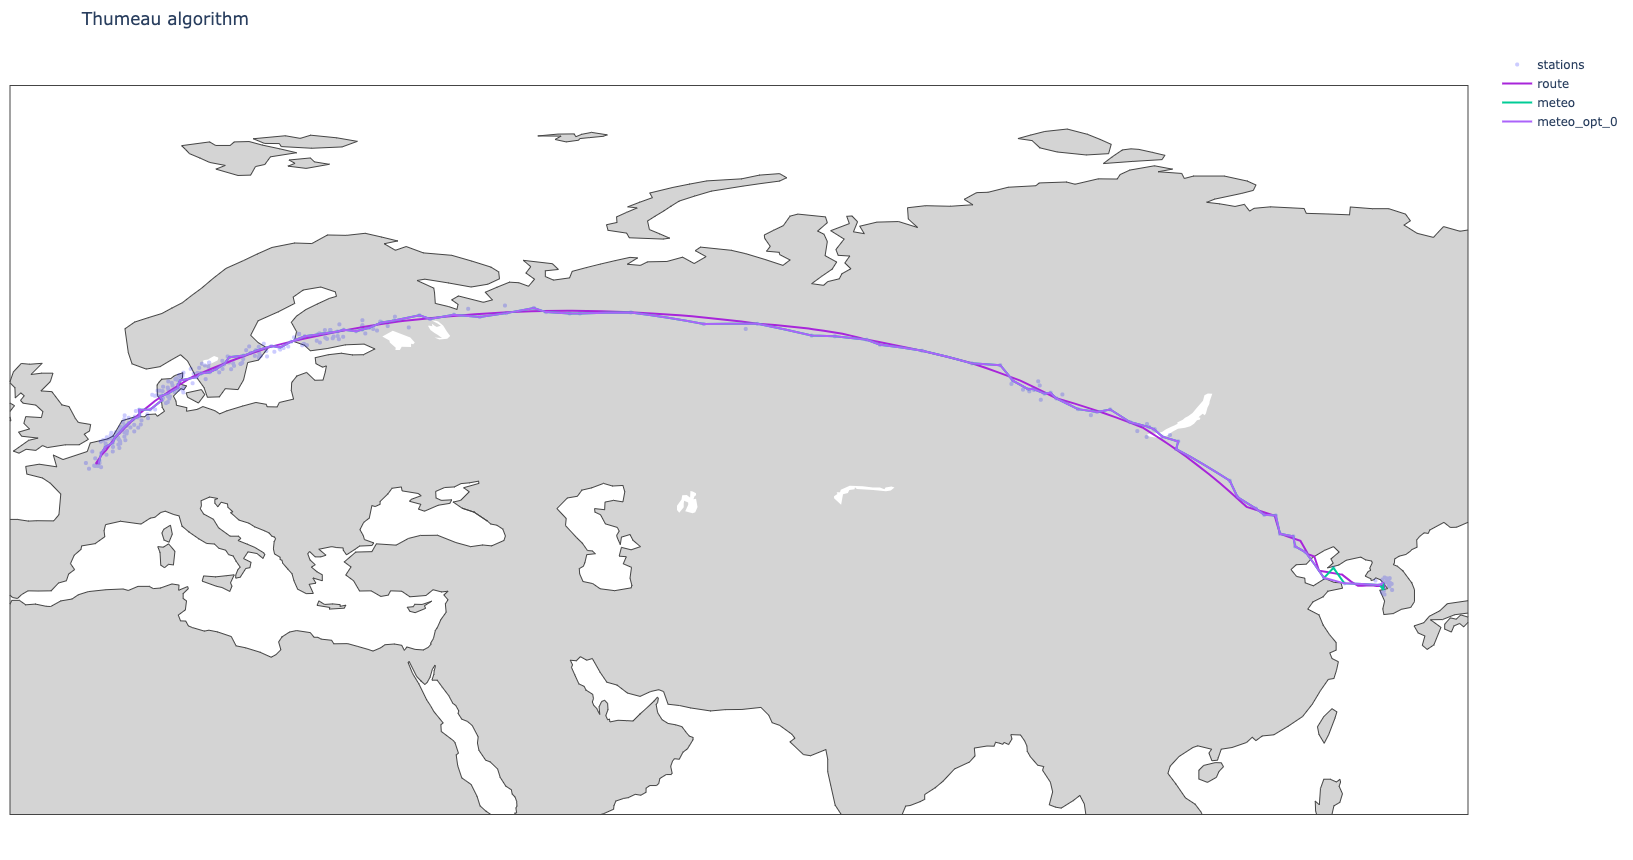

In [42]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scattergeo(
        lon=stations[:,1],
        lat=stations[:,0],
        mode='markers',
        name='stations',
        marker=dict(size=4, color='blue'),
        opacity=0.2,
))

fig.add_trace(go.Scattergeo(
        lon=route[:,1],
        lat=route[:,0],
        mode='lines',
        name='route',
        line=dict(width=2, color='#A825DA'),
))

fig.add_trace(go.Scattergeo(
        lon=np.degrees(path[:,1]),
        lat=np.degrees(path[:,0]),
        mode='lines',
        name='meteo',
        line=dict(width=2),
))

for i, best_path in enumerate(best_paths):
    fig.add_trace(go.Scattergeo(
        lat=best_path[:,0],
        lon=best_path[:,1],
        mode='lines',
        name='meteo_opt_' + str(i)))

fig.update_layout(
    legend=go.layout.Legend(orientation='v'),
    title='Thumeau algorithm',
    width=1440,
    height=860,
    geo=dict(
        landcolor="rgb(212, 212, 212)",
    ),
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=50,
        pad=4
    ),
)
fig.update_geos(fitbounds='locations')

In [43]:
from scipy.spatial.distance import cosine


In [44]:
def compute_penalty(path):
    return sum([cosine(path[i+1]-path[i], path[i]- path[i-1]) for i in range(1,len(path)-1)])

In [45]:
def compute_distances(path, route):
    return np.array([np.linalg.norm(path-r,axis=1)**2 for r in route])


In [46]:
distances = compute_distances(path, plane_route)

In [47]:
distance_dict = {i:min(distances[:, i]) for i in range(len(path))}

In [48]:
def l2_loss(distances, indices):
    dd = distances[:, indices]
    return sum(dd.min(axis=1))


In [49]:
def global_loss(path, route, distances, indices, l):
    return (np.log(l2_loss(distances, indices)) + l*compute_penalty(path[indices]))/len(indices)


In [50]:
from itertools import combinations
from tqdm import tqdm

In [51]:
def find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l):
    best_loss = global_loss(path, plane_route, distances, [i for i in range(len(path))], l )

    min_loss_path = path
    for k in tqdm(range(min_points_to_remove+1)):
        min_loss = N
        current_path = min_loss_path
        if len(current_path) <= len(path) - min_points_to_remove:
            break
        for p in combinations(range(1,len(current_path)-1), k):
            indices = [i for i in range(len(current_path)) if i not in p]
            new_loss = global_loss(current_path, plane_route, distances, indices, l)
            if new_loss < min_loss:
                min_loss = new_loss
                min_loss_path = current_path[indices]


    losses = [best_loss]
    current_path = min_loss_path
    best_path = min_loss_path
    print("length after min_removal", len(current_path))
    for k in tqdm(range(max_points_to_remove-min_points_to_remove+1)):
        for p in combinations(range(1,len(current_path)-1), k):
            indices = [i for i in range(len(current_path)) if i not in p]
            new_loss = global_loss(current_path, plane_route, distances, indices, l)
            if new_loss < best_loss:
                best_loss = new_loss
                losses.append(new_loss)
                best_path = current_path[indices]
    print("length after optimization", len(best_path))
    return best_path, losses

In [52]:
def plot_res(stations, plane_route, path, best_paths):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=stations[:,0], y=stations[:,1],
                        mode='markers',
                        name='stations'))
    fig.add_trace(go.Scatter(x=plane_route[:,0], y=plane_route[:,1],
                        mode='lines',
                        name='route'))
    fig.add_trace(go.Scatter(x=path[:,0], y=path[:,1],
                    mode='lines',
                    name='meteo'))
    for i, best_path in enumerate(best_paths):
        fig.add_trace(go.Scatter(x=best_path[:,0], y=best_path[:,1],
                            mode='lines',
                            name='meteo_opt_' + str(i)))
    return fig

In [53]:
min_points_to_remove = 5
max_points_to_remove = 8
best_paths = []
print("Meteo route length:", len(path))
for l in [0.1, 1, 10]:
    opt_path = find_opt_path(path, plane_route, distances, min_points_to_remove, max_points_to_remove, l)
    best_paths.append(opt_path[0])
    print(len(best_paths[-1]), opt_path[1])

  0%|          | 0/6 [00:00<?, ?it/s]

Meteo route length: 90


NameError: name 'N' is not defined

In [ ]:
plot_res(stations, plane_route, path, best_paths)
